**@author: James V. Talwar**

# Driver Mutation Presentation: AI MHC-I and Common Alleles

**About:** This notebook provides the code needed to generate Figure 3 panels C-E, Supplementary Figure 13 panel A, and Supplementary Figure 14 from the paper [*Autoimmune Alleles at the Major Histocompatibility Locus Modify Melanoma Susceptibility*](https://www.biorxiv.org/content/10.1101/2021.08.12.456166v1.full). These analyses evaluated AI MHC-I alleles ability to more effectively present driver mutations than common population alleles.

## 1. Import Packages; Load Data

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from collections import defaultdict
import tqdm

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
#get AI alleles
autoimmuneAlleles = set(pd.read_csv("../Data/AutoimmuneAlleles.tsv", sep = "\t", header = None)[0].tolist())
autoimmuneAlleles

{'HLA-B13:02',
 'HLA-B27:05',
 'HLA-B39:06',
 'HLA-B51:01',
 'HLA-B57:01',
 'HLA-C06:02',
 'HLA-C12:03'}

In [3]:
#Load in 215 driver mutations and associated MHC-I Best Rank Scores
affinityProfiles = pd.read_csv("../Data/Candidate_Drivers_BR_MHC1.tsv", sep = "\t", index_col = 0)
affinityProfiles.head()

,HLA-A02:167,HLA-A02:168,HLA-A02:169,HLA-A02:170,HLA-A02:171,HLA-B07:16,HLA-B07:17,HLA-B07:18,HLA-B07:19,HLA-B07:20,...,HLA-B07:78,HLA-B07:79,HLA-B07:80,HLA-B07:81,HLA-B07:82,HLA-B15:122,HLA-B15:123,HLA-B15:124,HLA-B15:125,HLA-B15:126
mutations,,,,,,,,,,,,,,,,,,,,,
M_TP53_C275Y,4.1534,4.6106,0.9139,1.8128,4.8308,13.9538,5.1807,9.9415,11.1954,14.5877,...,2.2612,11.9244,6.7736,21.6378,11.9244,1.6482,0.7227,1.1965,1.6482,1.7793
M_VEGFA_D198G,2.1415,1.9666,5.4024,3.3287,1.9311,4.1042,6.4720,3.9223,4.2464,8.8285,...,1.4582,3.3386,5.1494,11.1619,3.3386,9.0944,8.9867,12.4106,9.0944,8.9080
M_SEC22A_D23G,7.9141,9.8365,2.1085,4.5721,6.8805,1.0326,0.1415,0.9966,1.2675,1.2058,...,1.4956,1.5285,1.2330,0.8089,1.5285,0.7152,2.3788,3.8808,0.7152,0.8301
M_TMEFF1_Y107H,8.2554,7.3728,7.5933,3.9047,7.9749,14.7628,20.8333,16.9104,10.0483,11.7193,...,8.0138,13.8768,15.0040,16.4843,13.8768,2.7842,3.7512,4.8404,2.7842,2.5037
M_PPM1E_D246Y,7.9202,6.0824,9.2421,12.8691,4.6913,7.6801,2.4715,16.7910,9.6436,13.2814,...,8.1683,15.4333,10.4856,12.2825,15.4333,1.6243,1.7487,2.2919,1.6243,1.0131


Read in the population allele frequencies as defined by NMDP:

In [4]:
bFreq = pd.read_csv("../Data/HLA_Population_Frequencies/HLA_B.tsv", sep = "\t", index_col = 0)
bFreq = bFreq.sort_values(["USA NMDP European Caucasian (n=1242890) Allele Freq"], ascending = False)
bFreq.head()

,USA NMDP European Caucasian (n=1242890) Allele Freq
Allele,
B*07:02,0.131
B*08:01,0.114
B*44:02,0.095
B*15:01,0.061
B*35:01,0.056


In [5]:
cFreq = pd.read_csv("../Data/HLA_Population_Frequencies/HLA_C.tsv", sep = "\t", index_col = 0)
cFreq = cFreq.sort_values(["USA NMDP European Caucasian (n=1242890) Allele Freq"], ascending = False)
cFreq.head()

,USA NMDP European Caucasian (n=1242890) Allele Freq
Allele,
C*07:01,0.160
C*07:02,0.141
C*04:01,0.106
C*05:01,0.094
C*06:02,0.093


## 2. Data Processing and Formating: 

Define the set of common alleles that are not also an AI allele:

In [6]:
annoyinglyFormatted = set()
for el in autoimmuneAlleles:
    allele = el.split("-")[1]
    allele = allele[0] + "*" + allele[1:]
    annoyinglyFormatted.add(allele)
annoyinglyFormatted

{'B*13:02', 'B*27:05', 'B*39:06', 'B*51:01', 'B*57:01', 'C*06:02', 'C*12:03'}

In [7]:
bSubset = bFreq[(bFreq["USA NMDP European Caucasian (n=1242890) Allele Freq"] >= 0.01)& (~bFreq.index.isin(annoyinglyFormatted))]
cSubset = cFreq[(cFreq["USA NMDP European Caucasian (n=1242890) Allele Freq"] >= 0.01)& (~cFreq.index.isin(annoyinglyFormatted))]
commonAlleles = list(bSubset.index) + list(cSubset.index)

print("In total there are {} common population HLA-B (N = {}) and HLA-C (N = {}) alleles.".format(len(commonAlleles), bSubset.shape[0], cSubset.shape[0]))

In total there are 32 common population HLA-B (N = 19) and HLA-C (N = 13) alleles.


Compute the ECDF of driver mutations coverage for each allele: 

In [8]:
def BR_ECDF(matrixCol, rankThreshold = 2):
    stepSize = rankThreshold/len(affinityProfiles[matrixCol])
    toReturn = list()
    sanityCheck = list()
    areWeThereYet = 0
    while areWeThereYet <= rankThreshold:
        if areWeThereYet == 0:
            fractionPresented = float("-inf")
        elif areWeThereYet + stepSize > rankThreshold: #handles the weird case where won't be exactly 2 at the end and ensures it is 2
            areWeThereYet = rankThreshold
            fractionPresented = sum(affinityProfiles[matrixCol] <= areWeThereYet)/len(affinityProfiles[matrixCol])
        else:
            fractionPresented = sum(affinityProfiles[matrixCol] <= areWeThereYet)/len(affinityProfiles[matrixCol])
        
        toReturn.append(fractionPresented)
        sanityCheck.append(areWeThereYet)
        areWeThereYet += stepSize
    
    if len(toReturn) != (len(affinityProfiles[matrixCol]) + 1):
        raise ValueError("Dimension inconsistency - Number of steps does not match the number of mutations + 1.")
    
    return np.array(toReturn), np.array(sanityCheck)

In [9]:
affinityECDF = defaultdict(lambda: defaultdict(np.array))
for col in tqdm.tqdm(affinityProfiles.columns):
    affinityECDF[col]["x"], affinityECDF[col]["y"] = BR_ECDF(col) # x = Fraction of Driver mutations predicted to be presented at a binding threshold; y = binding threshold
    
print("ECDFs generated for {}/{} HLA-alleles.".format(len(affinityECDF), affinityProfiles.shape[1]))

100%|██████████| 2915/2915 [01:38<00:00, 29.53it/s]

ECDFs generated for 2915/2915 HLA-alleles.


Generate minimum and maximum population non-AI allele representation ECDFs for both HLA-B and HLA-C:

In [10]:
minB = []
maxB = []
for i in range(affinityProfiles.shape[0] + 1):
    localMin = float("inf")
    localMax = float("-inf")
    for ind in bSubset.index:
        properlyFormatted = "HLA-" + ind[0] + ind[2:]
        if affinityECDF[properlyFormatted]["x"][i] > localMax:
            localMax = affinityECDF[properlyFormatted]["x"][i]
        if affinityECDF[properlyFormatted]["x"][i] < localMin:
            localMin = affinityECDF[properlyFormatted]["x"][i]
            
    minB.append(localMin)
    maxB.append(localMax)

In [11]:
minC = []
maxC = []
for i in range(affinityProfiles.shape[0] + 1):
    localMin = float("inf")
    localMax = float("-inf")
    for ind in cSubset.index:
        properlyFormatted = "HLA-" + ind[0] + ind[2:]
        if affinityECDF[properlyFormatted]["x"][i] > localMax:
            localMax = affinityECDF[properlyFormatted]["x"][i]
        if affinityECDF[properlyFormatted]["x"][i] < localMin:
            localMin = affinityECDF[properlyFormatted]["x"][i]
            
    minC.append(localMin)
    maxC.append(localMax)

Generate AI and common allele rank score statistics for each driver mutation:

In [12]:
autoimmuneAlleleAverageDriverPresentation = defaultdict(lambda: defaultdict(float))
for mutation in affinityProfiles.index:
    rankScores = []
    for allele in autoimmuneAlleles:
        rankScores.append(affinityProfiles.loc[mutation, allele])
    autoimmuneAlleleAverageDriverPresentation[mutation]["AI_Mean"] = np.mean(rankScores)
    autoimmuneAlleleAverageDriverPresentation[mutation]["AI_Median"] = np.median(rankScores)
    autoimmuneAlleleAverageDriverPresentation[mutation]["AI_StdDev"] = np.std(rankScores)
    
    commonRank = []
    for allele in commonAlleles:
        properlyFormatted = "HLA-" + allele[0] + allele[2:]
        commonRank.append(affinityProfiles.loc[mutation, properlyFormatted])
    
    autoimmuneAlleleAverageDriverPresentation[mutation]["Common_Mean"] = np.mean(commonRank)
    autoimmuneAlleleAverageDriverPresentation[mutation]["Common_Median"] = np.median(commonRank)
    autoimmuneAlleleAverageDriverPresentation[mutation]["Common_StdDev"] = np.std(commonRank)

driverMutationPresentationByAlleleStatus = pd.DataFrame(autoimmuneAlleleAverageDriverPresentation).T

## 3. Run Analyses and Generate Figures

### 3a. Figure 3C-E: Fraction of Driver Mutations Presented by AI alleles and Population Allele Representations

**Fig 3C**:

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

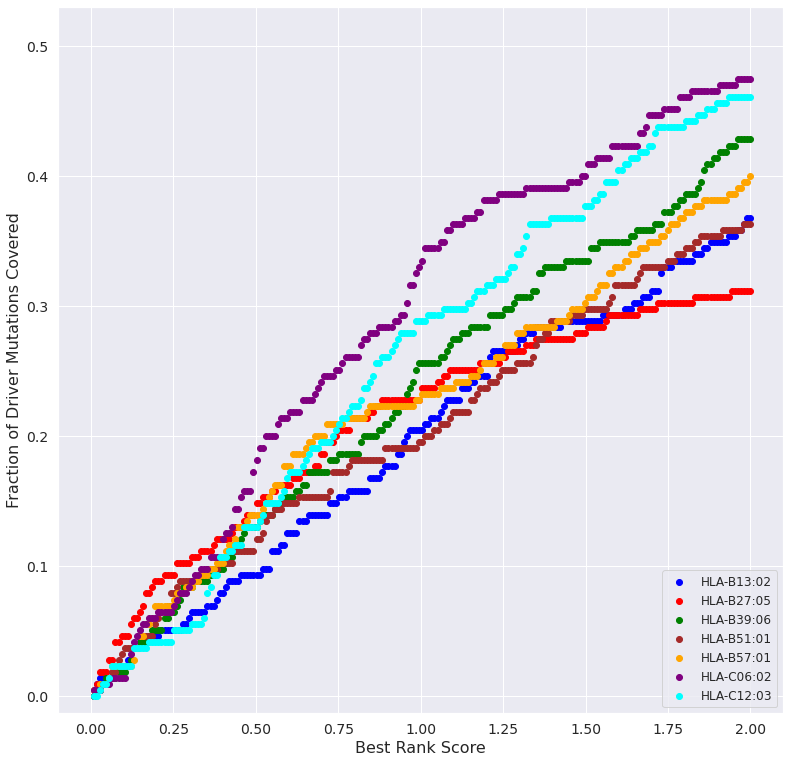

In [13]:
sns.set(font_scale=1.1)
plt.figure(figsize=(13,13))

plt.scatter(affinityECDF["HLA-B13:02"]["y"], y = affinityECDF["HLA-B13:02"]["x"], label = "HLA-B13:02", color = "blue")
plt.scatter(affinityECDF["HLA-B27:05"]["y"], y = affinityECDF["HLA-B27:05"]["x"], label = "HLA-B27:05", color = "red")
plt.scatter(affinityECDF["HLA-B39:06"]["y"], y = affinityECDF["HLA-B39:06"]["x"], label = "HLA-B39:06", color = "green")
plt.scatter(affinityECDF["HLA-B51:01"]["y"], y = affinityECDF["HLA-B51:01"]["x"], label = "HLA-B51:01", color = "brown")
plt.scatter(affinityECDF["HLA-B57:01"]["y"], y = affinityECDF["HLA-B57:01"]["x"], label = "HLA-B57:01", color = "orange")
plt.scatter(affinityECDF["HLA-C06:02"]["y"], y = affinityECDF["HLA-C06:02"]["x"], label = "HLA-C06:02", color="purple")
plt.scatter(affinityECDF["HLA-C12:03"]["y"], y = affinityECDF["HLA-C12:03"]["x"], label = "HLA-C12:03", color = "cyan")

plt.xlabel("Best Rank Score", fontsize = 16)
plt.ylabel("Fraction of Driver Mutations Covered", fontsize = 16)
plt.legend(loc = "lower right")

plt.xlim(-0.1,2.1)
plt.ylim(-0.013, 0.53)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

**Fig 3D: HLA-B and population representation**

(-0.013, 0.53)

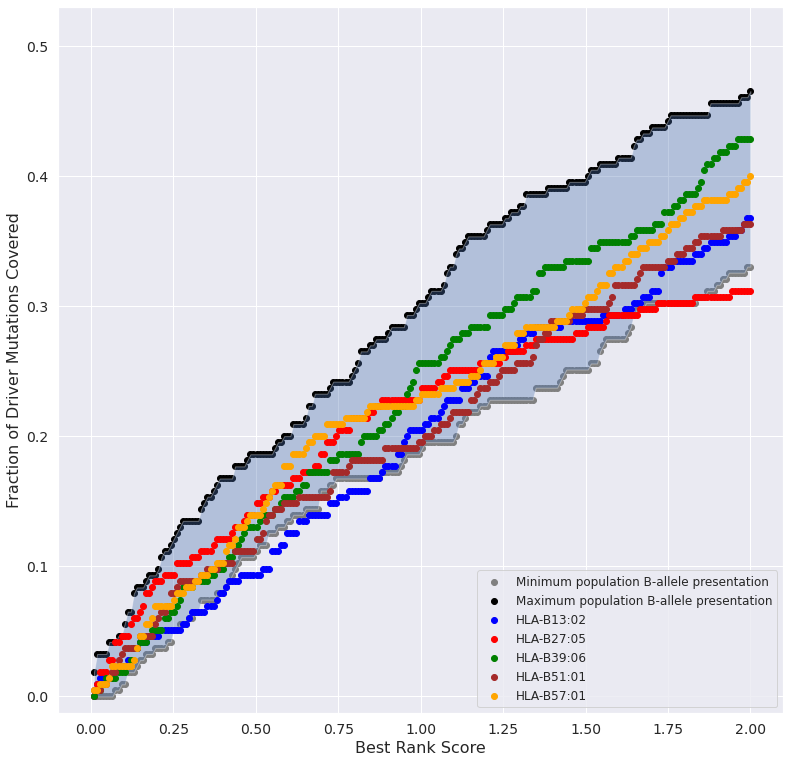

In [14]:
fig, ax = plt.subplots(figsize=(13, 13))

plt.scatter(affinityECDF["HLA-C06:02"]["y"], y = minB, label = "Minimum population B-allele presentation", color="grey")
plt.scatter(affinityECDF["HLA-C12:03"]["y"], y = maxB, label = "Maximum population B-allele presentation", color="black")
ax.fill_between(affinityECDF["HLA-B13:02"]["y"], minB, maxB, alpha = 0.35)
plt.scatter(affinityECDF["HLA-B13:02"]["y"], y = affinityECDF["HLA-B13:02"]["x"], label = "HLA-B13:02", color = "blue")
plt.scatter(affinityECDF["HLA-B27:05"]["y"], y = affinityECDF["HLA-B27:05"]["x"], label = "HLA-B27:05", color = "red")
plt.scatter(affinityECDF["HLA-B39:06"]["y"], y = affinityECDF["HLA-B39:06"]["x"], label = "HLA-B39:06", color = "green")
plt.scatter(affinityECDF["HLA-B51:01"]["y"], y = affinityECDF["HLA-B51:01"]["x"], label = "HLA-B51:01", color = "brown")
plt.scatter(affinityECDF["HLA-B57:01"]["y"], y = affinityECDF["HLA-B57:01"]["x"], label = "HLA-B57:01", color = "orange")

plt.xlabel("Best Rank Score", fontsize = 16)
plt.ylabel("Fraction of Driver Mutations Covered", fontsize = 16)
plt.legend(loc = "lower right")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-0.1,2.1)
plt.ylim(-0.013, 0.53)

**Fig 3E: HLA-C and population representation**


(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

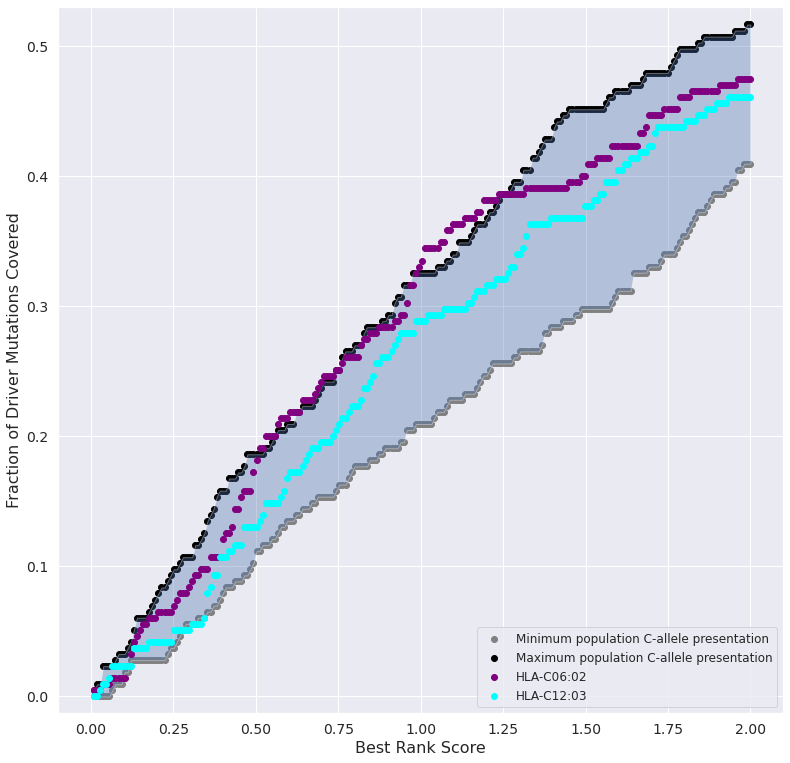

In [15]:
fig, ax = plt.subplots(figsize=(13, 13))

plt.scatter(affinityECDF["HLA-C06:02"]["y"], y = minC, label = "Minimum population C-allele presentation", color="grey")
plt.scatter(affinityECDF["HLA-C12:03"]["y"], y = maxC, label = "Maximum population C-allele presentation", color="black")
ax.fill_between(affinityECDF["HLA-C06:02"]["y"], minC, maxC, alpha = 0.35)
plt.scatter(affinityECDF["HLA-C06:02"]["y"], y = affinityECDF["HLA-C06:02"]["x"], label = "HLA-C06:02", color="purple")
plt.scatter(affinityECDF["HLA-C12:03"]["y"], y = affinityECDF["HLA-C12:03"]["x"], label = "HLA-C12:03", color = "cyan")

plt.xlabel("Best Rank Score", fontsize = 16)
plt.ylabel("Fraction of Driver Mutations Covered", fontsize = 16)
plt.legend(loc = "lower right")
plt.xlim(-0.1,2.1)
plt.ylim(-0.013, 0.53)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14) 

### 3b. Supplementary Figure 13A: Population Allele Representations Fraction of Driver Mutations Presented


(-0.013, 0.53)

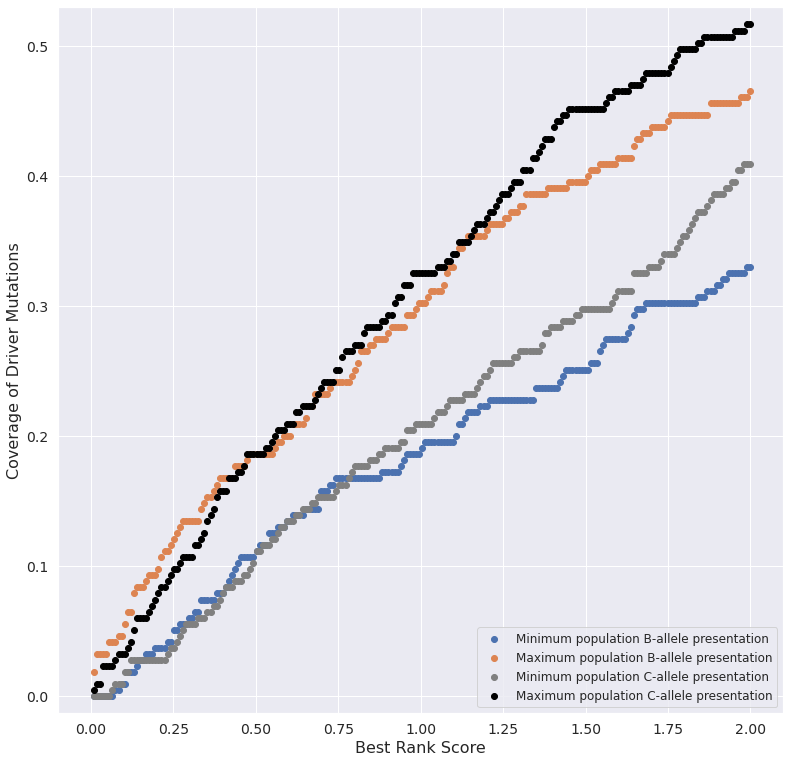

In [16]:
plt.figure(figsize = (13,13))
plt.scatter(affinityECDF["HLA-C06:02"]["y"], y = minB, label = "Minimum population B-allele presentation")
plt.scatter(affinityECDF["HLA-C12:03"]["y"], y = maxB, label = "Maximum population B-allele presentation")
plt.scatter(affinityECDF["HLA-C06:02"]["y"], y = minC, label = "Minimum population C-allele presentation", color="grey")
plt.scatter(affinityECDF["HLA-C12:03"]["y"], y = maxC, label = "Maximum population C-allele presentation", color="black")

plt.xlabel("Best Rank Score", fontsize = 16)
plt.ylabel("Coverage of Driver Mutations", fontsize= 16)
plt.legend(loc = "lower right")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(-0.1,2.1)
plt.ylim(-0.013, 0.53)

### 3c. Supplementary Figure 14: AI vs. Common Non-AI Alleles Median Driver Mutation Presentation

**Supp Fig. 14A**:

(-1.0, 31.5)

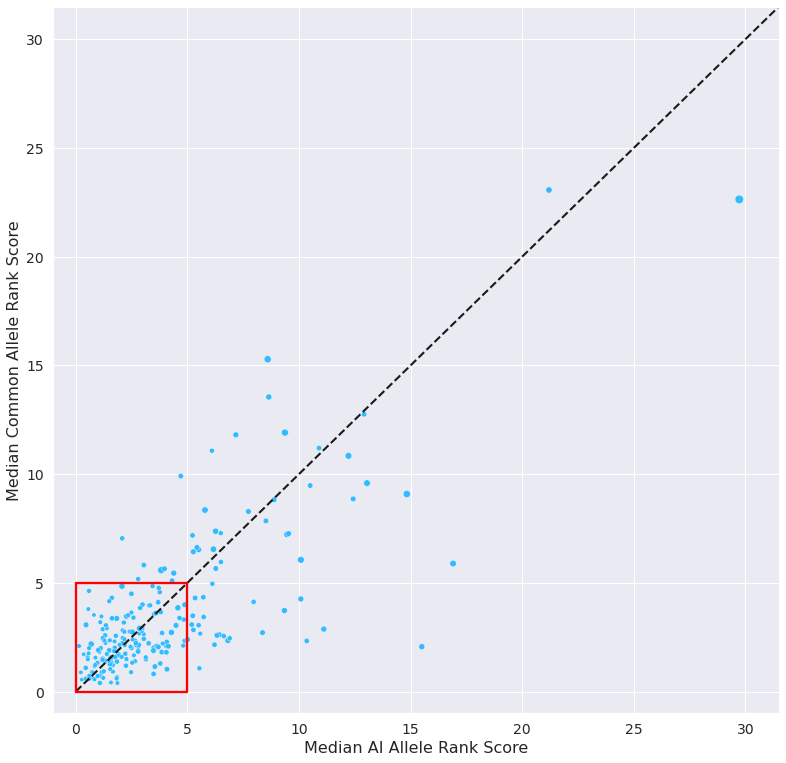

In [17]:
plt.figure(figsize = (13,13))
sns.scatterplot(data = driverMutationPresentationByAlleleStatus, x = "AI_Median", y = "Common_Median", size = "AI_StdDev", legend = False, color = "#33BBFF") #size = "AI_StdDev"

plt.plot([0, 33.6], [0, 33.6], 'k--', lw=2.1)
plt.plot([0, 5], [0, 0], lw=2.3, color = "red")
plt.plot([0, 5], [5, 5], lw=2.3, color = "red")
plt.plot([0, 0], [0, 5], lw=2.3, color = "red")
plt.plot([5, 5], [0, 5], lw=2.3, color = "red")
plt.xlabel("Median AI Allele Rank Score", fontsize = 16)
plt.ylabel("Median Common Allele Rank Score", fontsize= 16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(-1,31.5)
plt.ylim(-1, 31.5)

**Supp Fig. 14B:**


In [18]:
# For each mutation evaluate if there is a discrepancy in median presentation by 200% or more in either direction. Can annotate these points with the mutation. 
# Color by common vs AI allele status.

plotTheseMutationNames = defaultdict(list)

for i in driverMutationPresentationByAlleleStatus.index:
    mutationName = i.split("_")[1] + " " + i.split("_")[2]
    #AI allele better presenting mutations
    if driverMutationPresentationByAlleleStatus.loc[i, "Common_Median"] > 3*driverMutationPresentationByAlleleStatus.loc[i, "AI_Median"]:
        plotTheseMutationNames[mutationName] = [driverMutationPresentationByAlleleStatus.loc[i, "AI_Median"], driverMutationPresentationByAlleleStatus.loc[i, "Common_Median"], "AI_Better"]
    #Common allele better presenting mutations:
    elif driverMutationPresentationByAlleleStatus.loc[i, "Common_Median"] < driverMutationPresentationByAlleleStatus.loc[i, "AI_Median"]/3:
        plotTheseMutationNames[mutationName] = [driverMutationPresentationByAlleleStatus.loc[i, "AI_Median"], driverMutationPresentationByAlleleStatus.loc[i, "Common_Median"], "Common_Better"]

(-0.013, 5.0)

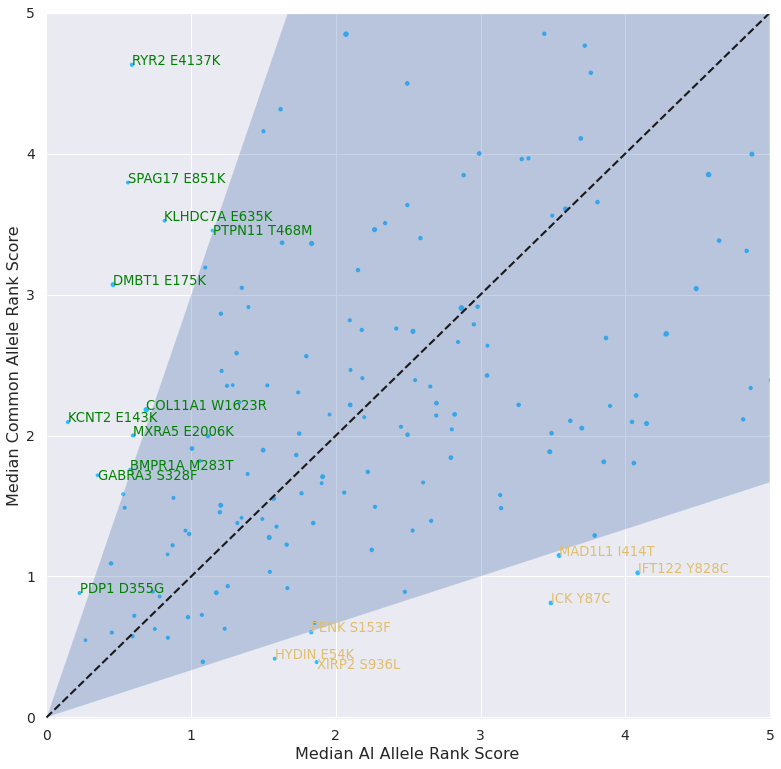

In [19]:
plt.figure(figsize = (13,13))
sns.scatterplot(data = driverMutationPresentationByAlleleStatus, x = "AI_Median", y = "Common_Median", size = "AI_StdDev", legend = False, color = "#33BBFF") #size = "AI_StdDev"
plt.plot([0, 5.1], [0, 5.1], 'k--', lw=2.1)

plt.fill_between(np.linspace(0,5,100), np.linspace(0,5,100)*3, np.linspace(0,5,100)/3, alpha = 0.31)

needsOffset = {"GABRA3 S328F", "PTPN11 T468M", "XIRP2 S936L"}
shift = .03
for k,v in plotTheseMutationNames.items(): 
    if (v[1] > 5) or (v[0] > 5):
        continue
    if v[2] == "AI_Better":
        if k in needsOffset:
            plt.annotate(k, (v[0], v[1]-0.03), color = "green") 
        else:
            plt.annotate(k, (v[0], v[1]), color = "green") 
        
    else:
        if k in needsOffset:
            plt.annotate(k, (v[0], v[1]-0.05), color = "#E1BE6A") 
        else:
            plt.annotate(k, (v[0], v[1]), color = "#E1BE6A") 
        
plt.xlabel("Median AI Allele Rank Score", fontsize = 16)
plt.ylabel("Median Common Allele Rank Score", fontsize= 16)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.xlim(-.013,5)
plt.ylim(-.013, 5)